# Автокодировщик

Представьте себе, что необходимо провести сжатие какого-либо сигнала. Причем такое сжатие должно быть обратимым - из сжатого представления мы должны получить обратно несжатое.

Если нам удалось сжать сигнал - значит в нем была избыточная информация.

Например, синусоидальный сигнал любой длины можно описать всего лишь несколькими числами - амплитудой, частотой и начальной фазой.

Если же в такой сигнал добавить случайный шум - то сжать его без потерь будет гораздо сложней.

Но ведь это способ для шумоочистки! Сожмем сигнал, при сжатии, конечно, потеряется часть информации, но для нашего примера это будет информация о шуме. Восстанавливая обратно сигнал из его сжатого представления - получаем очищенный сигнал.

Конечно с реальными сигналами все сложней, но подобный подход можно применить и для них.

На помощь приходят удивительные архитектуры нейронных сетей - **автокодировщики**.

Автокодировщик это модель (в т.ч. нейронная сеть) которая принимая на вход некий сигнал пытается воспроизвести его точную копию на выходе.

При этом модели запрещено тождественное преобразование. Тогда, хочешь-нехочешь, модели приходится так кодировать сигнал, чтобы при его декодировании точная копия все же получилась. Неважная информация - потеряется, важная - сохранится!

![img](https://neurohive.io/wp-content/uploads/2018/09/avtojenkoder-e1536675599885.png)

Автокодировщики могут быть использованы для обработки любых типов данных. Чтобы не допускать тождественного преобразования вход-выход, часто такие автокодировщики делают в архитектуре, когда сначала (часть "кодер") число нейронов в слое уменьшается, а потом (часть "декодер") увеличивается обратно. Существуют и другие подходы, например разреженные автокодировщики, когда на промежуточные выходы слоев накладывают требования, уменьшающие число свободных параметров.   

## Детектирование аномалий в сигнале
Используем нейросетевой автокодировщик, чтобы обнаружить аномалии в сигнале.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Набор данных


Для примера загрузим данные об электрокардиограммах (ЭКГ), набор  [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). Здесь представлено 5,000 эклектрокардиограмм, каждая из 140 отсчетов. Приведены бинарные метки классов `0` (ненормальный ритм) и `1` (нормальный ритм).

Когда известны примеры обоих классов - это типовая задача классификации. Однако, один из классов может отсутствовать или же быть очень редким.

Будем считать, что у нас нет класса с ненормальным - **аномальным** -  ритмом (ведь, чтобы он появился кто-то, врач-эксперт, должен его распознать).

Какже обнаружить такой аномальный класс?

Давайте сделаем модель *нормального* класса, а все, что сильно отличается от нее и будем считать аномальным!

Значит задача автокодировщика - смоделировать примеры нормального класса. Так мы и поступим, заставим нашу модель *пытаться* воспроизвести на выходе сигнал кардиограммы такой же, как на входе. Обучаться же модель будет только на нормальном классе.

Сможет - будем считать что это нормальная кардиограмма. Не сможет - аномалия. Для различения введем порог для сравнения этих ситуаций.

Набор данных из [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [2]:
# загружаем набор
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
# последний столбец - метка класса, извлечем
labels = raw_data[:, -1]

# остальные столбцы - сама кардиограмма, ее отсчеты
data = raw_data[:, 0:-1]

# разделим на обучающие и тестовые
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Нормализуем к диапазону `[0,1]`.


In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Обучаться будем только на нормальном классе `1`, отделим данные.

In [5]:
train_labels = train_labels.astype(bool) # обучающие примеры
test_labels = test_labels.astype(bool) # тестовые примеры

normal_train_data = train_data[train_labels] #  только нормальные обучающие
normal_test_data = test_data[test_labels] #  только нормальные тестовые

anomalous_train_data = train_data[~train_labels] # аномальные (не используем)
anomalous_test_data = test_data[~test_labels] # аномальные тестовые

Нарисуем нормальные ЭКГ.

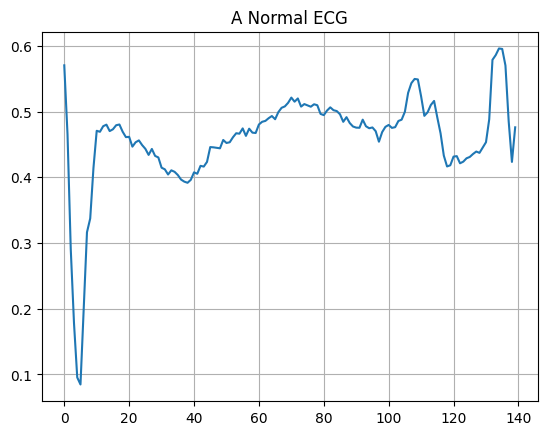

In [6]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Нарисуем аномальные ЭКГ.

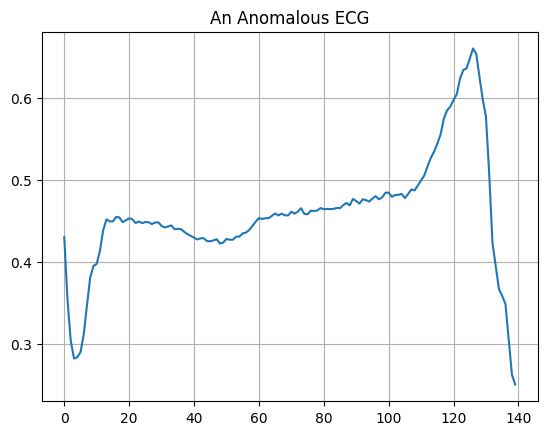

In [7]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

## Модель автокодировщика
Создадим модель. Здесь используем многослойный персептрон, состоящий из двух частей:
* Кодер - размер слоев уменьшается, произвордит сжатие информации
* Декодер - размер слоев увеличивается, разжимает информацию.
Размер выхода декодера такой же, как размер входа кодера (140 элементов).   

In [8]:
class AnomalyDetector(Model):
  def __init__(self): # инициализация
    super(AnomalyDetector, self).__init__()
    # кодер
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    # декодер
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x): # расчет выхода
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [9]:
# опции обучения модели
autoencoder.compile(optimizer='adam', loss='mae')

Обучаем автокодировщик только на нормальном классе! Входы и указания учителя здесь это одинаковые массивы.

In [10]:
# обучаем
history = autoencoder.fit(
    normal_train_data, # входы
    normal_train_data, # выходы
    epochs=20, # число эпох
    batch_size=512, # размер пакета
    validation_data=(test_data, test_data), # тестовые данные
    shuffle=True) # перемешивать

Epoch 1/20
5/5 [==============================] - 9s 115ms/step - loss: 0.0580 - val_loss: 0.0531
Epoch 2/20
5/5 [==============================] - 0s 31ms/step - loss: 0.0557 - val_loss: 0.0512
Epoch 3/20
5/5 [==============================] - 0s 30ms/step - loss: 0.0524 - val_loss: 0.0491
Epoch 4/20
5/5 [==============================] - 0s 29ms/step - loss: 0.0484 - val_loss: 0.0470
Epoch 5/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0439 - val_loss: 0.0446
Epoch 6/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0394 - val_loss: 0.0420
Epoch 7/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0355 - val_loss: 0.0406
Epoch 8/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0323 - val_loss: 0.0391
Epoch 9/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0297 - val_loss: 0.0380
Epoch 10/20
5/5 [==============================] - 0s 23ms/step - loss: 0.0277 - val_loss: 0.0373
Epoch 11/20
5/5 [===========

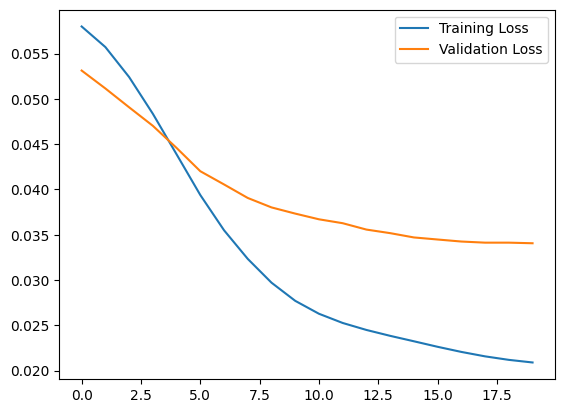

In [11]:
# графики ошибок
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Сначала проверим, наколько хорошо данные восстанавливаются для нормального и аномального классов.

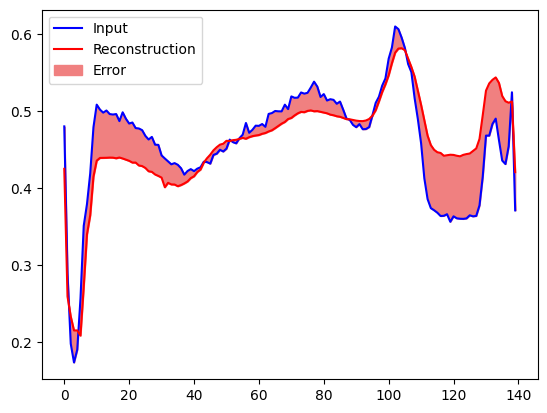

In [12]:
#  нормальные
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

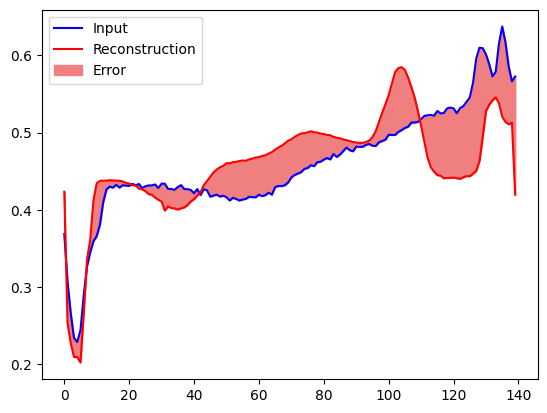

In [13]:
# аномальные
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Мы видим, что нормальные данные восстанавливаются гораздо лучше. Тогда как на аномальных данных получаем большие ошибки.

### Детектирование аномалий

Чтобы отличить нормальные данные от аномальных, нужно ввести порог для сравнения. Ошибка восстановления меньше порога - нормальные; выше порога - аномальные.

От выбора порога будет сильно зависеть результат. Давайте посмотрим, а какие ошибки мы получали на разных классах, построим гистограммы ошибок.


74/74 [==============================] - 0s 3ms/step


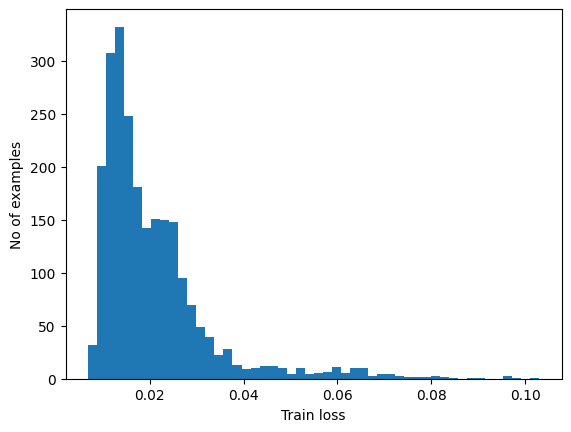

In [14]:
# нормальные
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

14/14 [==============================] - 0s 5ms/step


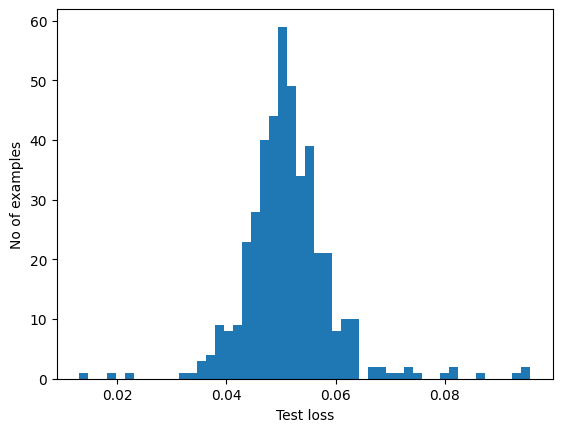

In [15]:
# аномальные
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
#reconstructions = autoencoder.predict(anomalous_train_data)
#test_loss = tf.keras.losses.mae(reconstructions, anomalous_train_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Видим, что ошибки дествительно различаются.
Выберем порог как величину средней ошибки для нормального класса  плюс одно стандарное отклонение. Можно выбрать и другим способом.

In [16]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033114213


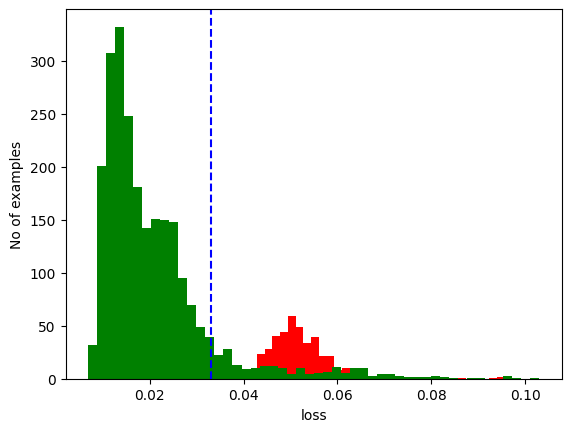

In [17]:
# вместе

plt.hist(test_loss[None, :], bins=50, color='r')
plt.hist(train_loss[None, :], bins=50, color='g')
plt.axvline(x = threshold, color = 'b', ls='--')
plt.xlabel("loss")
plt.ylabel("No of examples")
plt.show()

Выбрав порог, теперь можем отличать классы друг от друга.Считаем ошибку восстановления (здесь mae), сравниваем с порогом.


In [18]:
# возвращает класс "1" или "0" при заданном пороге
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

# качество классификации
def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [19]:
# считаем качество классификации на тестовых данных
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571


Получилось замечательно!

# Упражнения

* Подберите другое значение порога, проверьте качество.
* сделайте другую архитектуру автокодировщика, проверьте качество.
* попробуйте другие сигналы.

[Интерактивный пример](https://anomagram.fastforwardlabs.com/#/)

Пример [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html)

[Про автокодировщики](https://blog.keras.io/building-autoencoders-in-keras.html)

Также см. в главе 14 из книги [Deep Learning](https://www.deeplearningbook.org/)



# Ссылки

Использованы и адаптированы материалы:

Copyright 2020 The TensorFlow Authors.

In [20]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb
